# Exploring Shuffling Methods

I play a lot of card games, and am always worried about how well I shuffle. Whenever I deal up a new hand and get what seems like an unlikely sequence of cards, I can't help but question whether I've shuffled enough. To overcome my concerns, I typically err on the side of over shuffling and mixing up the ways that I shuffle. That works, but I wonder, what are the best methods of shuffling and how many times do I need to shuffle a deck before it should be considered randomized?

I'm going to try to answer these questions by exploring different methods of shuffling through simulations and a little statistics. I will also shuffle up some cards physically and collect some data to see how theory compares to practice.

I'm sure plenty of other people have done this kind of thing, and a quick Google or YouTube search could give me all of the answers I'm looking for. But it seems like more fun to find the answers myself, so here I go.

In [1]:
import sys

import numpy as np
%matplotlib widget 
from matplotlib import pyplot as pl

sys.path.append('../src/')
import shufflers as s
import stats
import visualization as v

I'm going to run my analysis against a 60 card deck, common in several Trading Card Games (TCGs) including [Flesh and Blood's](https://fabtcg.com) Classic Constructed format, which is what I'm playing most these days.

I'll start with an unshuffled deck, which I'll represent as an array of integers encoding the starting position of each card in the deck (starting from position 0).

In [2]:
fresh_deck = np.arange(60)

In [3]:
fresh_deck

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

I've implemented several shuffler classes (see accompanying module `../src/shufflers.py` for details), each with a `shuffle` method that takes a deck (an array of integers as above), shuffles it *once* according to the shuffling strategy implemented in the class, and returns a new array with the shuffled cards. 

For example, here is a class that shuffles by randomly cutting the deck roughly in half, then exchanges the order of the two halves.

In [4]:
shuffler = s.CutShuffler()
shuffler.shuffle(fresh_deck)

array([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
       15, 16, 17, 18, 19, 20, 21, 22, 23])

## Measuring the shuffled-ness of a deck

I'm not sure the best way to measure how well a deck has been shuffled, but one way that I thought of is to count the final difference in positions between two cards that were next to one another before shuffling. For example, in the `fresh_deck` above, cards 0 and 1 at the top of the deck start next to one another. After shuffling, we can measure the absolute difference between the shuffled positions of cards 0 and 1. I'll call this the "Distance Between Initially Neighboring Cards", DBINC, or just distance. 

For a perfectly shuffled deck, we would expect the DBINC to follow a specific distribution. If the deck weren't shuffled properly, we would find that certain distances would be over or under represented. What is the expected distribution?

The smallest distance between cards is 1 and the largest possible distance is the size of the deck minus 1 (59 in this case).

I would expect a higher probability of measuring a small distance than a large distance because there are more deck configurations where short distances are possible than large distances. Consider the following example for a 5 card deck.

There are 8 possible configurations for cards 0 and 1 to be 1 position apart after shuffling.
```
0 1 X X X
X 0 1 X X
X X 0 1 X
X X X 0 1
1 0 X X X
X 1 0 X X
X X 1 0 X
X X X 1 0
```

There are 6 possible configurations for cards 0 and 1 to be 2 positions apart.
```
0 X 1 X X
X 0 X 1 X
X X 0 X 1
1 X 0 X X
X 1 X 0 X
X X 1 X 0
```

There are 4 possible configurations for cards 0 and 1 to be 3 positions apart.
```
0 X X 1 X
X 0 X X 1
1 X X 0 X
X 1 X X 0
```

There are 2 possible configurations for cards 0 and 1 to be 4 positions apart.
```
0 X X X 1
1 X X X 0
```


So the probability distribution for distance between two cards would look like

```
*
* *
* * *
* * * *
-------
1 2 3 4
```

Counting out different configurations, for a perfectly randomized deck we should expect a linear decrease in probability from the minimum distance of 1 to the maximum given that for each larger distance there are fewer possible configurations where two cards can be separated by the given distance.

I've written a function to calculate the distribution of initially neighboring card distances for a given deck size (see `../src/stats.py`). Let's look at some statistics and plot the distribution.


In [5]:
dists, ideal_distro = stats.ideal_distro(fresh_deck)
ideal_stats = stats.ideal_distro_stats(dists, ideal_distro)

In [6]:
for k in ideal_stats:
    print(f'{k:>4}: {ideal_stats[k]:>5.2f}')

mean: 20.33
 5th:  2.00
25th:  8.00
75th: 30.00
95th: 47.00


Text(0.5, 1.0, 'Distribution of distances\nfor an ideally shuffled deck')

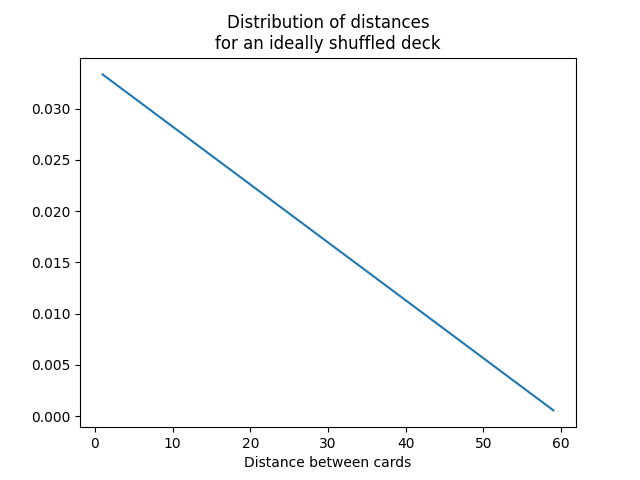

In [7]:
pl.figure()
pl.plot(dists, ideal_distro)
pl.xlabel('Distance between cards')
pl.title('Distribution of distances\nfor an ideally shuffled deck')

This result is already pretty interesting. Imagine you're shuffling up a fresh set of cards, all in order. Maybe you just built a new deck or you opened a new pack of playing cards. The fact that it is much more likely for two cards that start next to one another to end up close to one another than it is for them to be split up on opposite sides of the deck after shuffling is not what I would have naively expected. This might lead to my perception that I haven't shuffled well when I find two of the same cards next to one another... I must not have shuffled well enough, right? Well no, it's actually bound to happen even for a perfectly shuffled deck.

## Simulating different shuffling methods

Let's go ahead and simulate shuffling up some cards, compute final distances between two initially neighboring cards, and compare to the ideal distribution. 

To help understand what's going on, I've got a couple of methods here to visualize how well shuffled the deck is after N shuffles (see `../src/visualization.py`). We will look at the histogram of distances between our marked card and its neighbor after N shuffles. We will also look at percentiles of the distribution over N shuffles, comparing to the statistics of the ideal distribution above, to more easily see how the distribution evolves.

### Ideal shuffler

Let's start by looking at a "perfect shuffler" that completely randomizes the deck each shuffle.

In [8]:
ideal_sim_results = s.simulate_shuffling(fresh_deck, s.IdealShuffler)

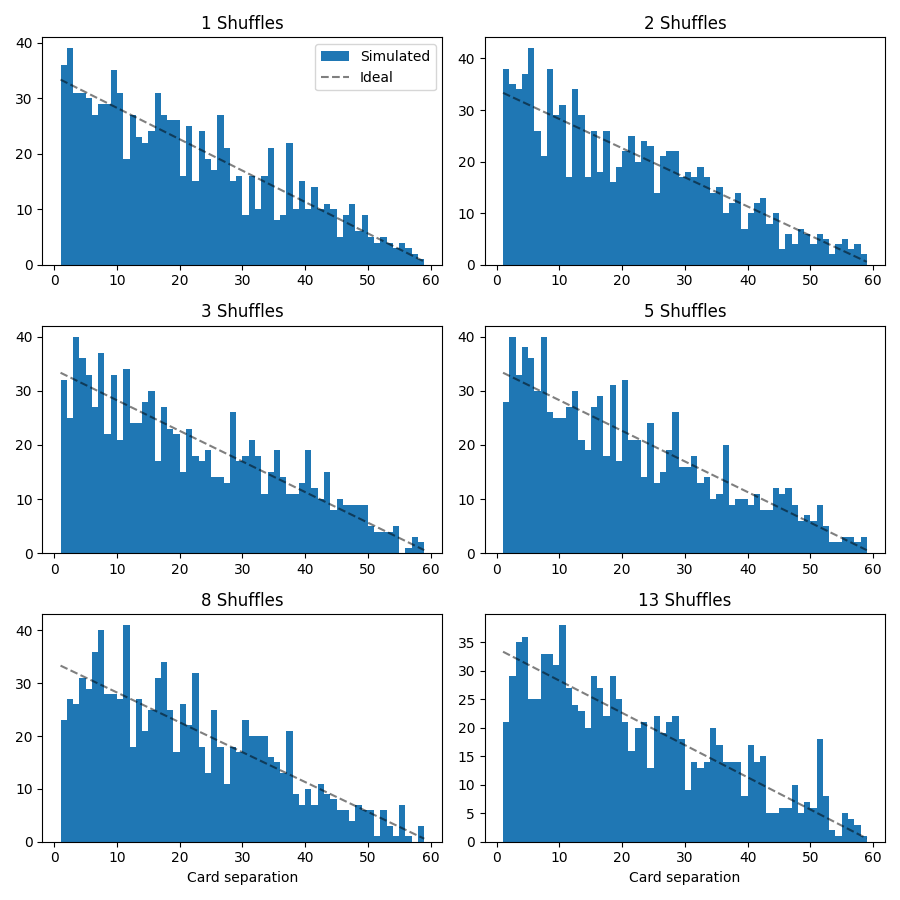

In [9]:
v.plot_histograms(ideal_sim_results, dists, ideal_distro)

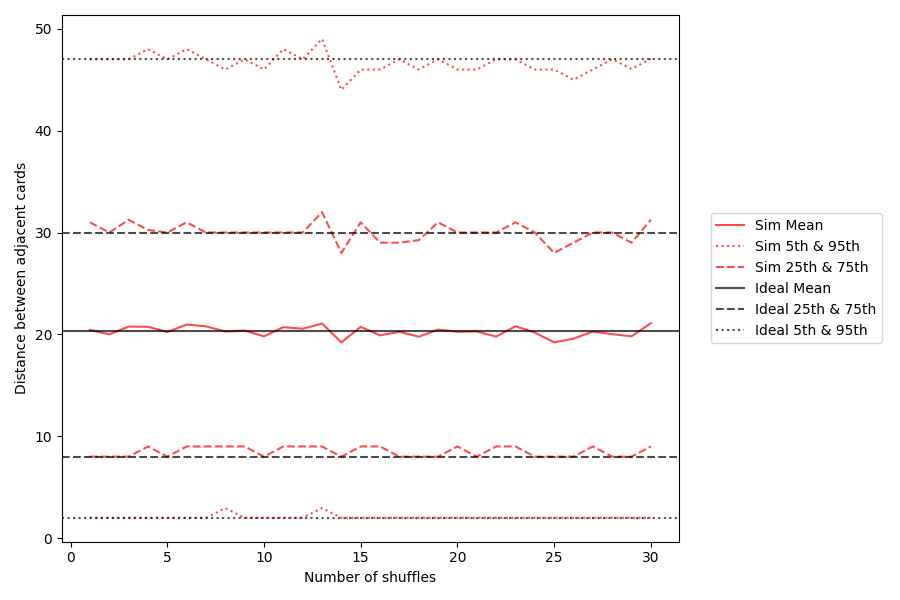

In [10]:
ideal_sim_stat_trends = v.plot_sim_summary(ideal_sim_results, ideal_stats)

We see the linear decrease in probability for each distance as expected. The simulated results match the true distribution (shown as a dashed line) quite closely. With more simulations, I would expect this to get closer and closer to the ideal.

Of course, we get a perfectly randomized deck after just a single shuffle with this method, but we need a computer or something to put it into practice. It's useful to have it here for comparison though.

### Cut shuffler

A simple method of shuffling involves cutting a deck repeatedly, then putting the cut parts of the deck back together in a different order. The randomness introduced by this method comes from the exact position of the cut. 

This isn't often used by itself, but in combination with other methods. Let's see how well it works on its own, though. Let's start with a single cut.

In [11]:
cut_sim_results = s.simulate_shuffling(fresh_deck, s.CutShuffler, n_shuffles=2000)

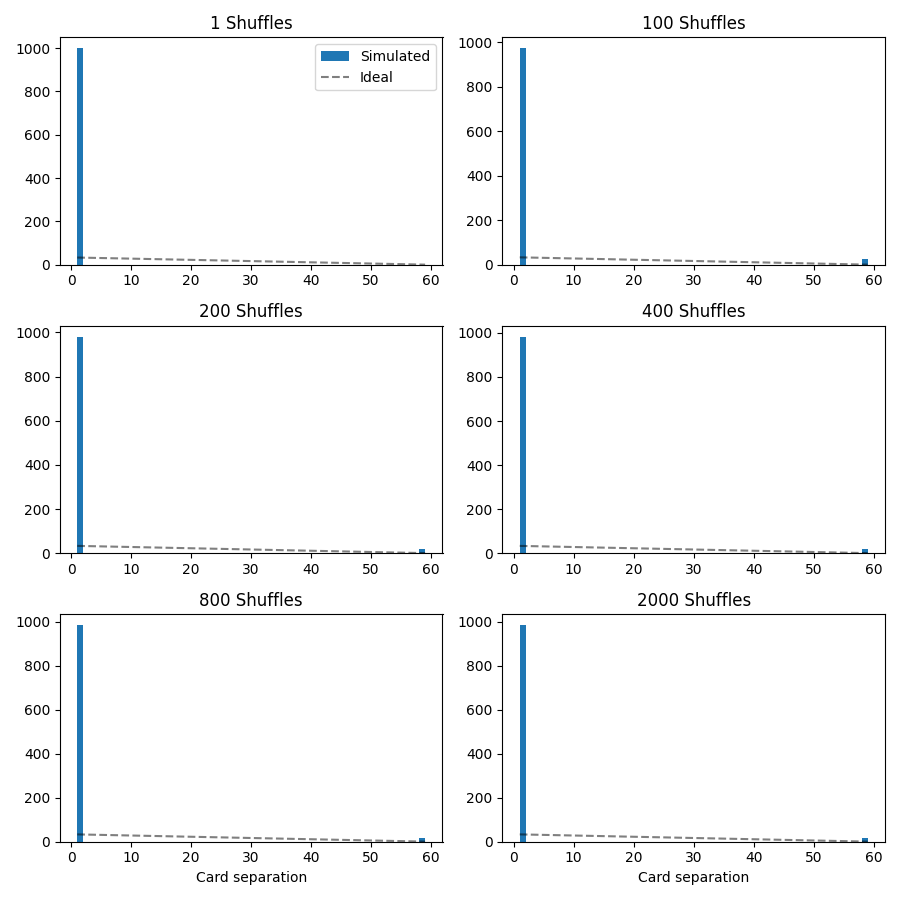

In [12]:
v.plot_histograms(cut_sim_results, dists, ideal_distro, keys=[1, 100, 200, 400, 800, 2000])

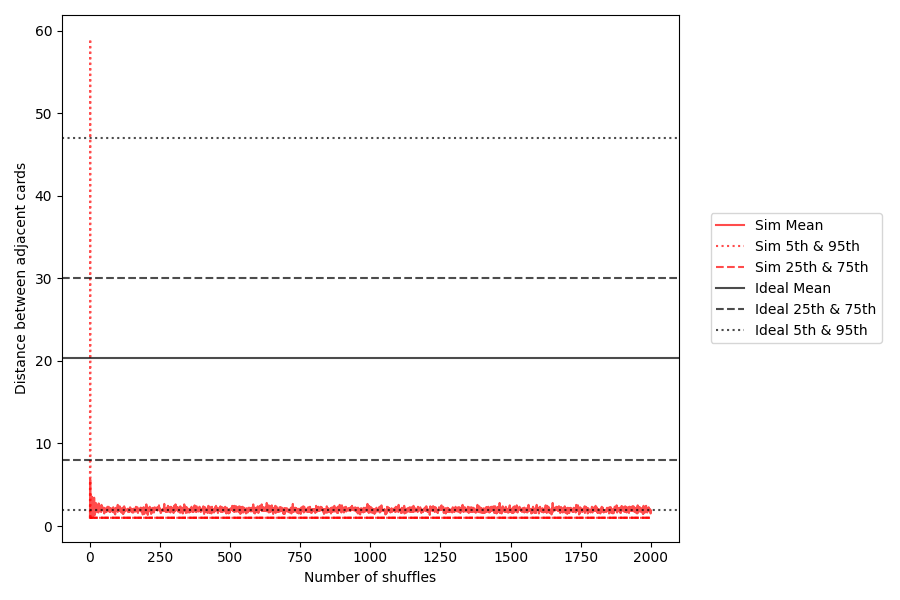

In [13]:
_ = v.plot_sim_summary(cut_sim_results, ideal_stats)

Not surprisingly, this doesn't really shuffle the deck. This is especially true considering I'm measuring the distance between cards originally at the top of the deck.

Does cutting the deck into ~thirds manage to shuffle the cards?

In [14]:
tricut_sim_results = s.simulate_shuffling(fresh_deck, s.TriCutShuffler, n_shuffles=300)

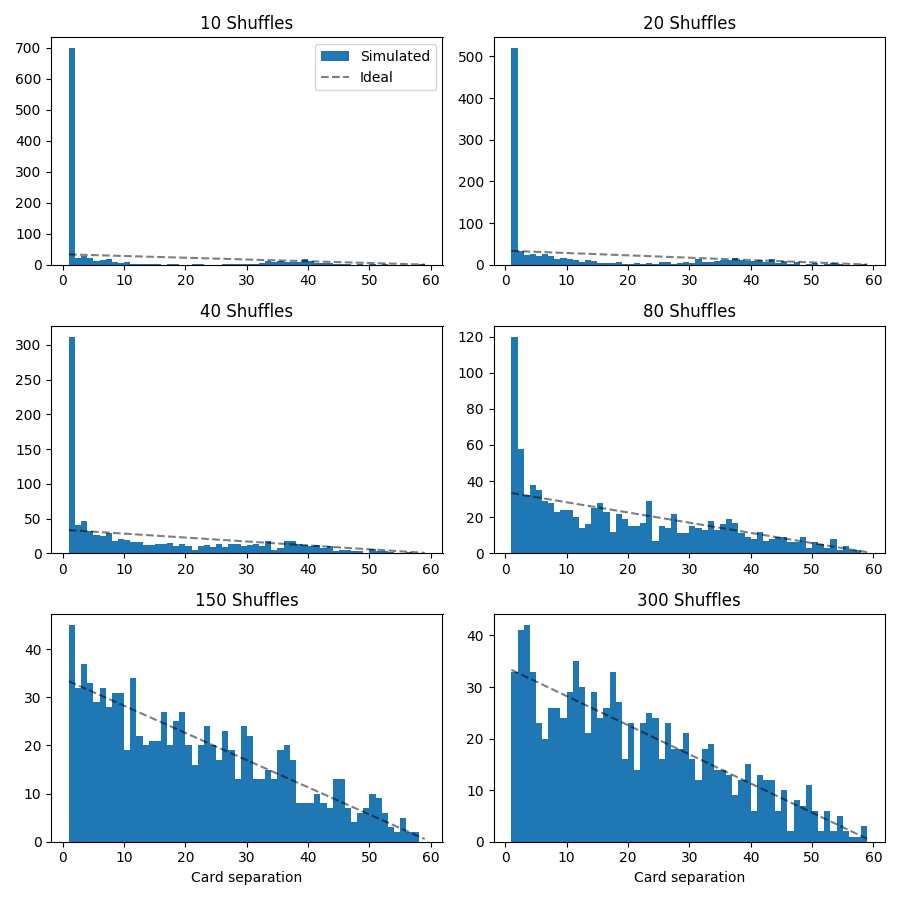

In [15]:
v.plot_histograms(tricut_sim_results, dists, ideal_distro, keys=[10, 20, 40, 80, 150, 300])

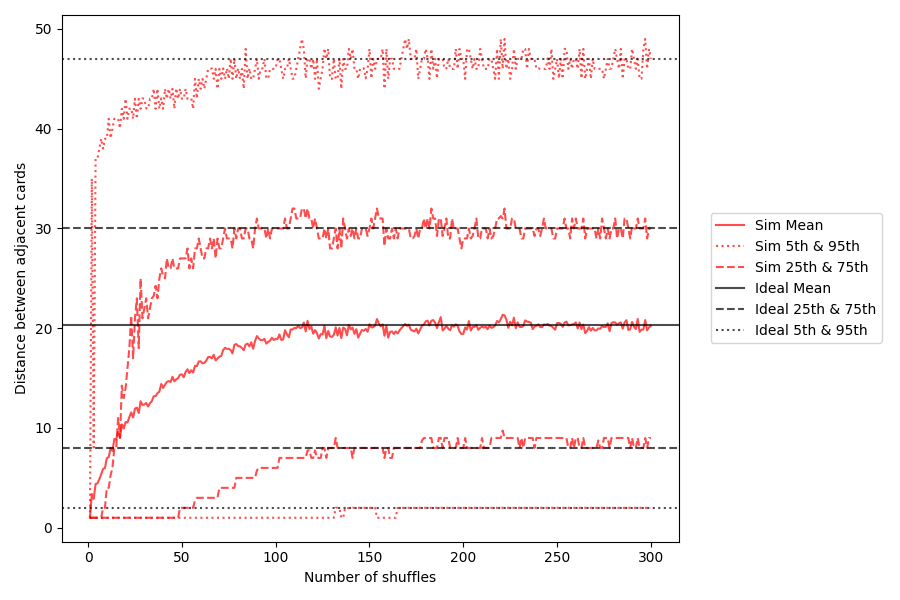

In [16]:
_ = v.plot_sim_summary(tricut_sim_results, ideal_stats)

It takes a while (>100 shuffles), but eventually tripple cut shuffling does shuffle the deck. I presume cutting in two would eventually shuffle the deck as well, but it might take many more shuffles? 

### Riffle shuffler

Let's look at the most common form of shuffling, "riffle shuffling". This method involves cutting a deck in half, then randomly interleaving the cards from the two halves back together. You can do this via "bridge shuffling" like you do with a standard deck of playing cards. Most TCG players don't bridge shuffle for fear of bending their (sometimes quite expensive) cards. With a sleeved set of cards you can achieve the same result by stacking the two cut halves and kind of smashing the top half down into the bottom half (which I'll call "smash shuffling"). I'll consider both bridge shuffling and smash shuffling to be forms of riffle shuffling that work the same as far as my simulation is concerned. 

I've simulated riffle shuffling with a random distribution of the number of cards inserted into the new deck from one half before switching back to introduce cards from the other. The distribution I draw from is as follows:

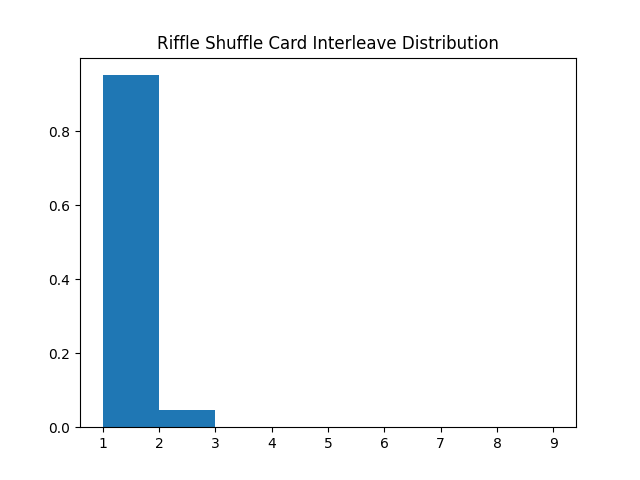

In [17]:
pl.figure()
pl.hist((np.random.poisson(0.05, size=10000) + 1), bins=np.arange(1, 10), density=True)
pl.title('Riffle Shuffle Card Interleave Distribution');

This distribution says that about 95% of the time we'll take one card from one half before switching back to take a card from the next half.  Around 5% of the time we'll get two cards from one half before switching back to the other. Rarely we'll get a larger number of cards from one half in a row. Observing my own riffle shuffling (via smash shuffling), this distribution seemed about correct. Later we can investigate the effect of changing this distribution and other parameters of the shuffler.

In [18]:
riffle_sim_results = s.simulate_shuffling(fresh_deck, s.RiffleShuffler)

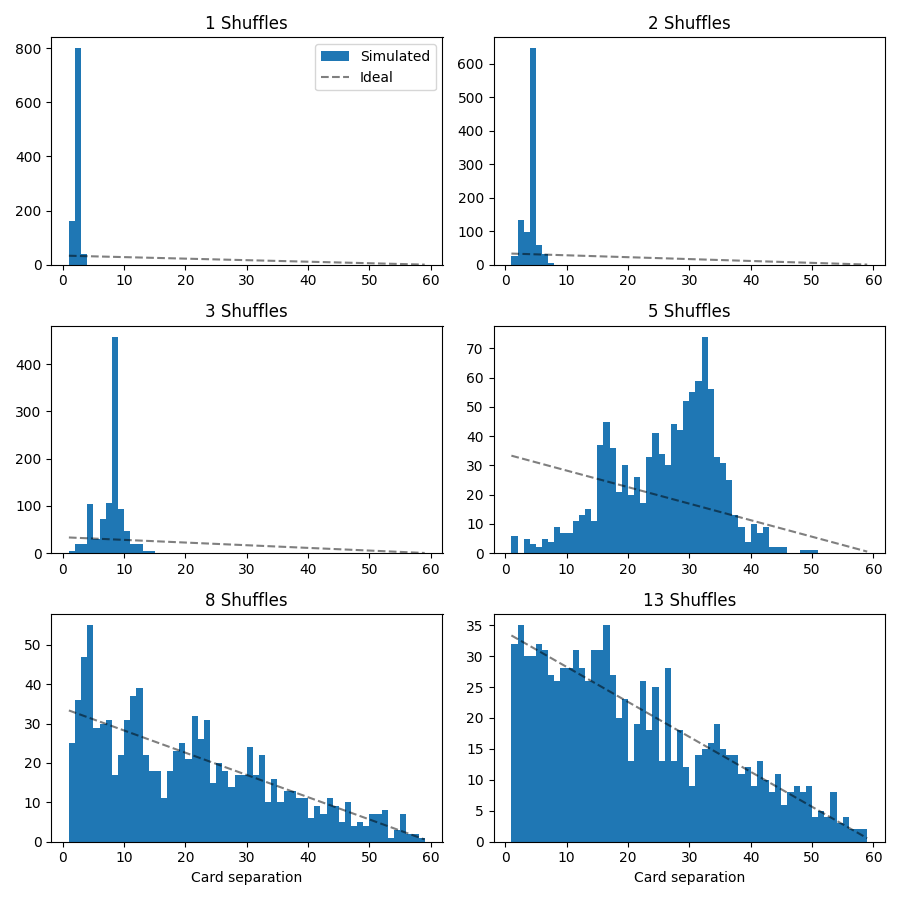

In [19]:
v.plot_histograms(riffle_sim_results, dists, ideal_distro)

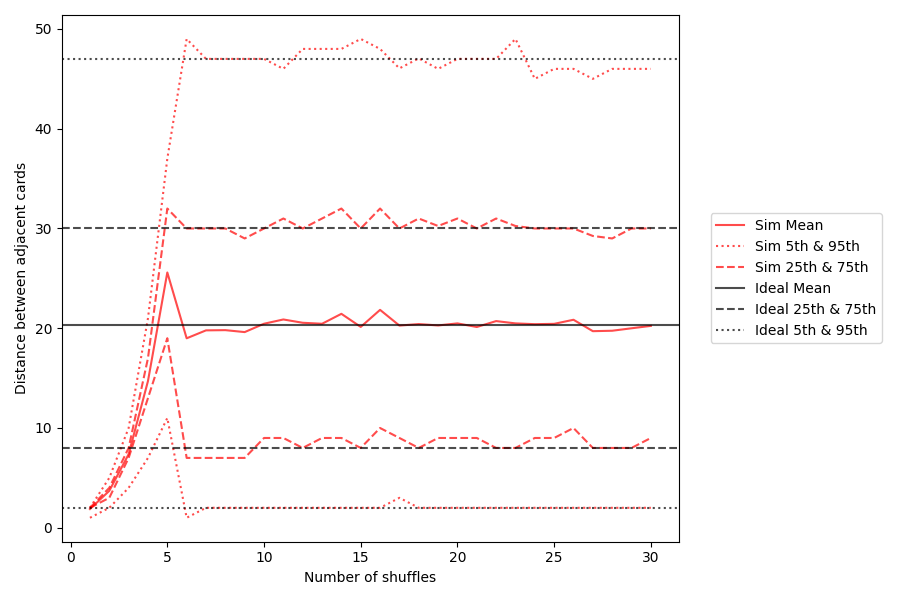

In [20]:
_ = v.plot_sim_summary(riffle_sim_results, ideal_stats)

After only one or two riffle shuffles, cards that are initially close to one another tend to stay quite close to one another. It takes quite a few shuffles to allow cards to drift apart. Interstingly, after 5 shuffles, middling card separations of 20-40 are still very over-represented and you're less likely than expected to have two initially neighboring cards next to one another or maximally separated. Comparing the distribution of card separations to the ideal distribution, it looks like it takes somewhere north of 10 shuffles to get a randomized distribution using the riffle shuffling method. 

I will say that this result very likely depends on how well a riffle shuffle is executed, most critically whether the shuffler tends to always put the two halves of the deck together in the same order (e.g. cards from the half in their left hand are always put to the top of the shuffled deck). You can imagine that if this were the case, the cards toward the top of the shuffled deck wouldn't get shuffled at all. In my simulated shuffler, I randomly select which half is put first, and something like that is important to put into practice. Cutting the deck every once in a while helps protect against poor implementation of the riffle shuffle, so it probably doesn't hurt to do it anyway.

### Pile shuffler

The last kind of shuffling that I'll analyze is so called pile shuffling. This is something a lot of TCG players do to shuffle their cards gently. It involves dealing out cards into some number of piles, then re-assembling the piles *in a random order*. Note that dealing cards out sequentially and picking them up sequentially does not randomize the deck at all (although it does redistribute the cards).

In [21]:
pile_7_sim_results = s.simulate_shuffling(fresh_deck, s.RandomPickupPileShuffler, n_piles=7)

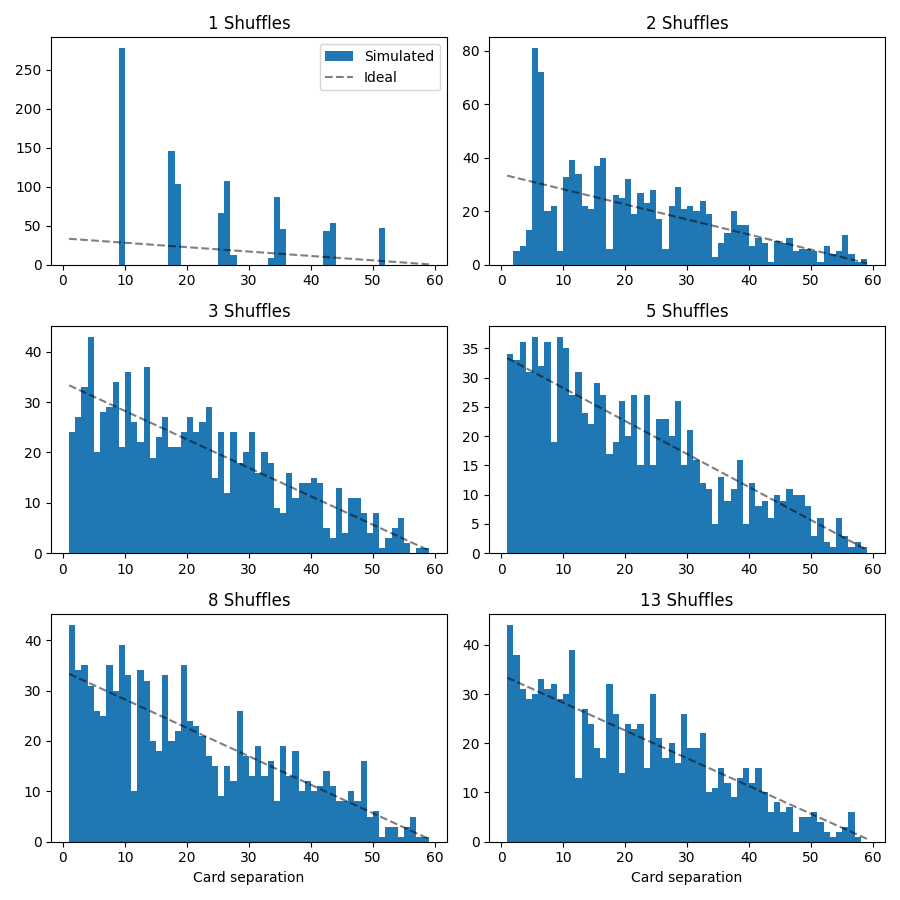

In [22]:
v.plot_histograms(pile_7_sim_results, dists, ideal_distro)

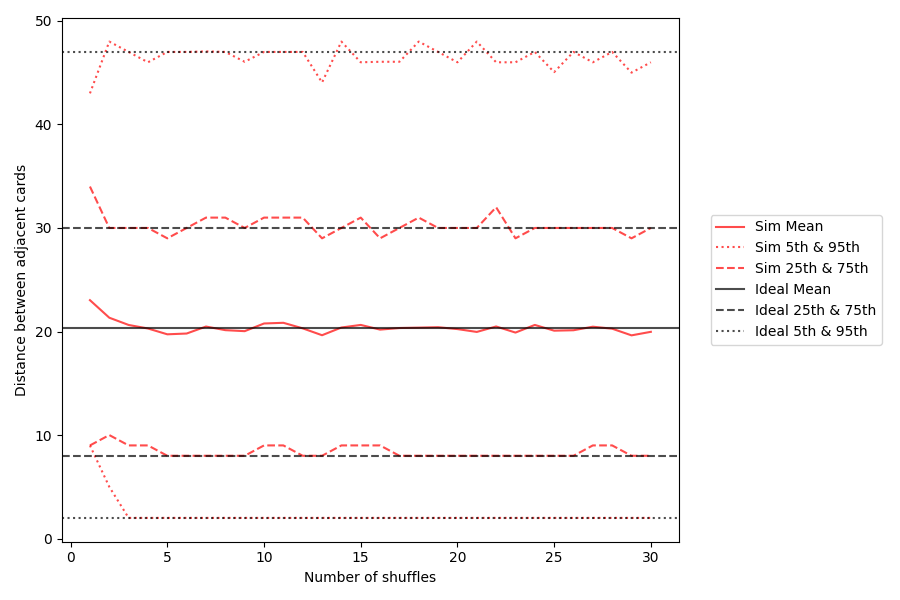

In [23]:
_ = v.plot_sim_summary(pile_7_sim_results, ideal_stats)

With this method, we start with a very limited number of distances between cards, but unlike with riffle shuffling, we're distributing cards better across the range of possible separations. The initially "spikey" distribution persists for a few shuffles but eventually cards spread out throughout the deck.

Surprisingly (to me), this seems to achieve randomness with fewer shuffles than riffle shuffling, seemingly around 3-4 shuffles. 

We'll see later that this result depends critically on the number of piles.

## Measuring randomness, part 2

I'm feeling pretty good about using the ultimate distance between a marked card and its initial neighbor in a deck as a measure of how well the deck is shuffled. I'm also feeling pretty good about my shuffle simulations.

Above I'm visualizing distribtions of DBINCs over a bunch of simulations and comparing to the "ideal" to determine when a deck is sufficiently randomized. At this point I'd like to explore parameters of different shuffling methods (e.g. number of piles, how cards are interleaved in a riffle shuffle, etc.), but comparing distributions visually as above isn't going to scale well.

I need a simple metric to determine when the distance distributions are sufficiently similar to the ideal shuffler for any given shuffling strategy. The [Kullback-Leibler Divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) is just such a metric, measuring similarity between two distribution. See the `../src/stats.py` module for my implementation. 

The KL divergence will allow us to compare two distributions, but what is the KL divergence of the distribution of a well shuffled deck? The KL divergence always >= 0, and is only equal to 0 if the two distributions being compared are exactly equal. The more dissimilar two distributions are, the larger the KL divergence.

We can get a sense of what a sufficient KL divergence would be by comparing simulated ideal shuffler distribution to the analytical ideal distribution. 

In [24]:
ideal_kl_divs = stats.get_kl_divs(ideal_sim_results, ideal_distro)

In [25]:
ideal_kl_mean = np.mean(ideal_kl_divs)
ideal_kl_std = np.std(ideal_kl_divs)
ideal_kl_thresh = np.mean(ideal_kl_divs) + 2 * np.std(ideal_kl_divs)
print(f"KL divergence of ideal shuffler simulations compared to the analytical ideal distribution: {ideal_kl_mean:.4f} +- {2 * ideal_kl_std:.4f}")

KL divergence of ideal shuffler simulations compared to the analytical ideal distribution: 0.0291 +- 0.0110


So we see that ~95% of ideal simulations have a KL divergence within ~0.01 of 0.03. If I simulate another shuffling strategy, and the KL divergence relative to the analytical ideal comes in below < 0.04 or so, I should be able to consider the deck well shuffled for whatever shuffling parameters were simulated.

Let's use the KL divergence to analyze some results observed through visual comparison above, namely that it only takes a few pile shuffles to randomize a deck, and it takes >5 shuffles to randomize via riffle shuffling.

In [26]:
riffle_kl_divs = stats.get_kl_divs(riffle_sim_results, ideal_distro)
pile_7_kl_divs = stats.get_kl_divs(pile_7_sim_results, ideal_distro)

In [27]:
n_shuffles = sorted(riffle_sim_results.keys())

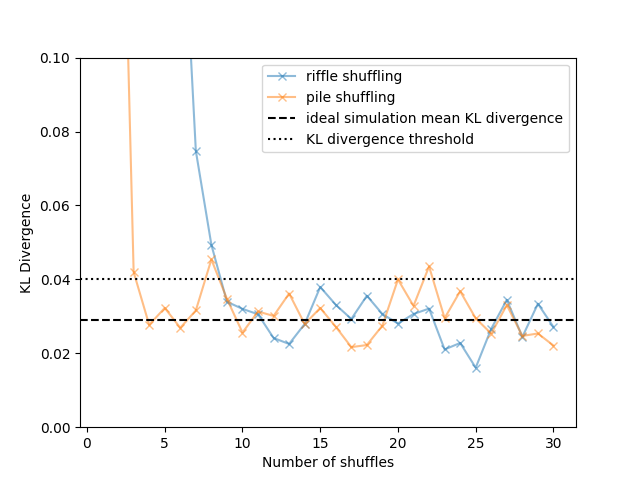

In [28]:
pl.figure()
pl.plot(n_shuffles, riffle_kl_divs, marker='x', alpha=0.5, label='riffle shuffling')
pl.plot(n_shuffles, pile_7_kl_divs, marker='x', alpha=0.5, label='pile shuffling')
pl.axhline(ideal_kl_mean, ls='--', c='k', label='ideal simulation mean KL divergence')
pl.axhline(ideal_kl_thresh, ls=':', c='k', label='KL divergence threshold')
pl.legend()
pl.ylim([0, 0.05])
pl.xlabel('Number of shuffles')
pl.ylabel('KL Divergence')
pl.ylim([0, 0.1]);

Comparing the KL divergences of pile and riffle simulations to the threshold we determined above, we see that pile shuffling achieves randomness by shuffle 4 while riffle shuffling requires 2x as many shuffles, not reaching randomness until shuffle 8. These reuslts depend on exactly how both shuffling approaches are carried out. Below we'll use the KL divergence as a means of exploring impact of varying parameters of each method.

This metric seems to work well, confirming what we found visually above. 


## Deck position

In the above simulations, I'm measuring the distance between cards that were initially at the top of the deck (cards 0 and 1). Do I get different results depending on the card I mark, i.e. do the cards mix in at different rates depending on where they start in the deck?

Let's look at riffle shuffling results marking the middle cards instead of the top cards.

In [29]:
riffle_sim_results_mid = s.simulate_shuffling(fresh_deck, s.RiffleShuffler, marked_card=29)

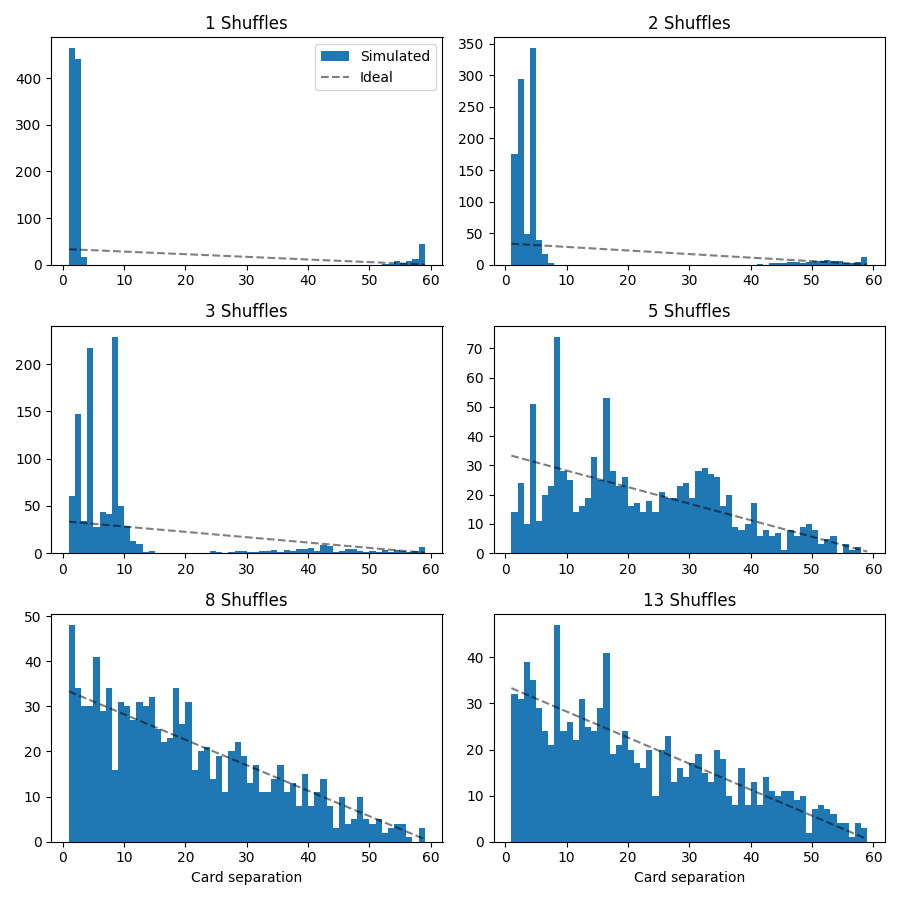

In [30]:
v.plot_histograms(riffle_sim_results_mid, dists, ideal_distro)

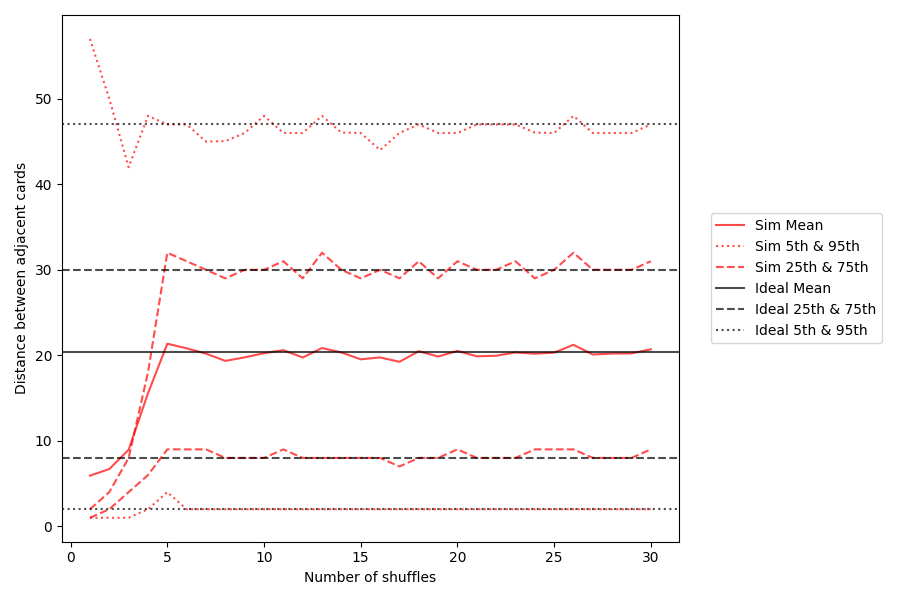

In [31]:
_ = v.plot_sim_summary(riffle_sim_results_mid, ideal_stats)

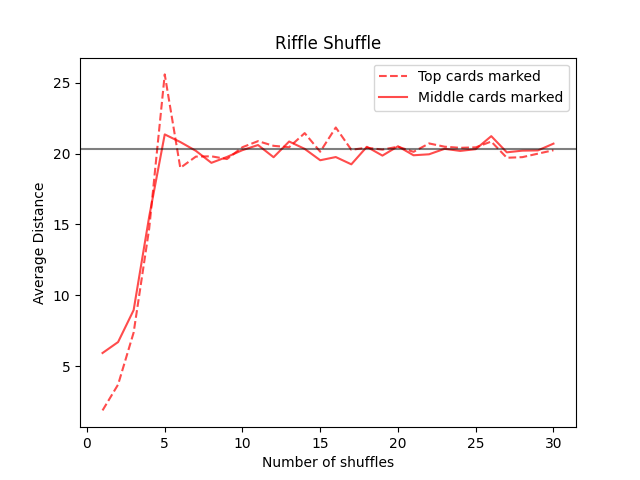

In [32]:
pl.figure()

n_shuffles = sorted(riffle_sim_results.keys())
riffle_sim_stats = stats.get_sim_stats(riffle_sim_results)
riffle_sim_mid_stats = stats.get_sim_stats(riffle_sim_results_mid)

pl.plot(n_shuffles, riffle_sim_stats['mean'], 'r--', alpha=0.7, label='Top cards marked')
pl.plot(n_shuffles, riffle_sim_mid_stats['mean'], 'r', alpha=0.7, label='Middle cards marked')
pl.xlabel('Number of shuffles')
pl.ylabel('Average Distance')
pl.axhline(ideal_stats['mean'], c='k', alpha=0.5)
pl.title('Riffle Shuffle')
pl.legend();

In [33]:
marked_cards = np.arange(0, 33, 3)
required_shuffle_count = []

for mc in marked_cards:
    these_sim_results = s.simulate_shuffling(fresh_deck, s.RiffleShuffler, marked_card=mc)
    these_kl_divs = stats.get_kl_divs(these_sim_results, ideal_distro)
    this_reqd_shuffle_count = 1 + np.where(these_kl_divs < ideal_kl_thresh)[0][0]  
    required_shuffle_count.append(this_reqd_shuffle_count)    

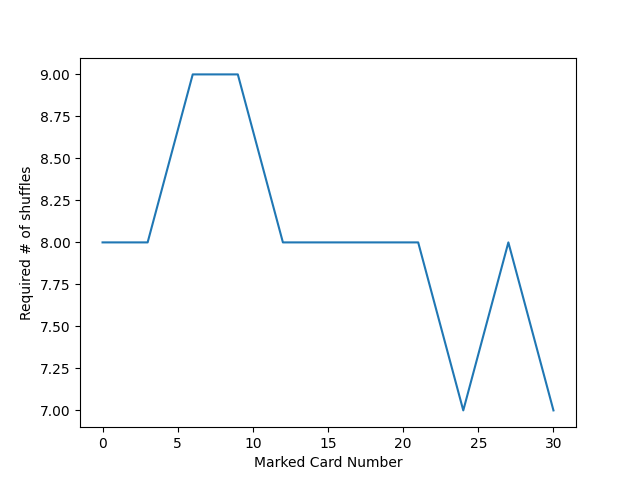

In [34]:
pl.figure()
pl.plot(marked_cards, required_shuffle_count)
pl.xlabel('Marked Card Number')
pl.ylabel('Required # of shuffles');

The cards at the middle of the deck seem to get shuffled slightly faster (1-2 shuffles fewer) than the cards at the end, which makes sense.

What about for the pile shuffler?

In [35]:
pile_sim_results_mid = s.simulate_shuffling(fresh_deck, s.RandomPickupPileShuffler, marked_card=29)

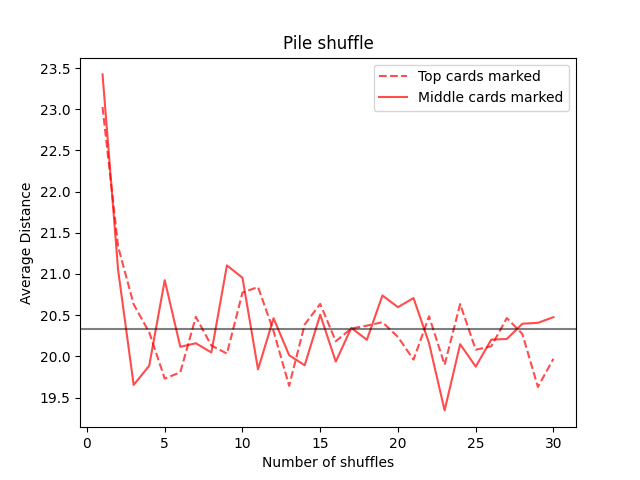

In [36]:
pl.figure()

n_shuffles = sorted(pile_7_sim_results.keys())
pile_sim_stats = stats.get_sim_stats(pile_7_sim_results)
pile_sim_mid_stats = stats.get_sim_stats(pile_sim_results_mid)

pl.plot(n_shuffles, pile_sim_stats['mean'], 'r--', alpha=0.7, label='Top cards marked')
pl.plot(n_shuffles, pile_sim_mid_stats['mean'], 'r', alpha=0.7, label='Middle cards marked')
pl.xlabel('Number of shuffles')
pl.ylabel('Average Distance')
pl.axhline(ideal_stats['mean'], c='k', alpha=0.5)
pl.title('Pile shuffle')
pl.legend();

The marked card doesn't seem to matter for pile shuffling. Again, this makes sense to me.

I'm going to assume based on the above, and my intuition, that the cards at the top/bottom will always take the same number of shuffles or longer to shuffle in than any other cards in the deck, and therefore will default to using the top (or equivalently bottom) card to measure how thoroughly a deck has been shuffled.
## Exploring shuffling parameters

We can see some useful trends and results visually above. So far I'm learning that pile shuffling, in terms of number of shuffles, shuffles a deck pretty quickly. Riffle shuffling takes more shuffles, especially to make sure all cards are mixed in throughout the deck. I'm kind of surprised at how few shuffles are required to mix cards via pile shuffling, honestly.

How sensitive are results to the particulars of each shuffling method. Number of piles in a pile shuffle, how exactly cards are interleaved with a riffle shuffle, effect of mixing different shuffling methods, all make a difference. 

I have a bunch of other questions at this point:

### Optimal number of piles for a pile shuffle

What is the optimal number of piles for a pile shuffle?

In [37]:
n_piles = np.arange(2, 15)
pile_7_kl_divs = []
pile_7_reqd_shuffles = []

for n_p in n_piles:

    these_pile_sim_results = s.simulate_shuffling(fresh_deck, s.RandomPickupPileShuffler, n_piles=n_p)
    these_kl_divs = stats.get_kl_divs(these_pile_sim_results, ideal_distro)
    try:
        these_reqd_shuffles = np.where(these_kl_divs <= ideal_kl_thresh)[0][0] + 1
    except IndexError:
        these_reqd_shuffles = None

    pile_7_reqd_shuffles.append(these_reqd_shuffles)

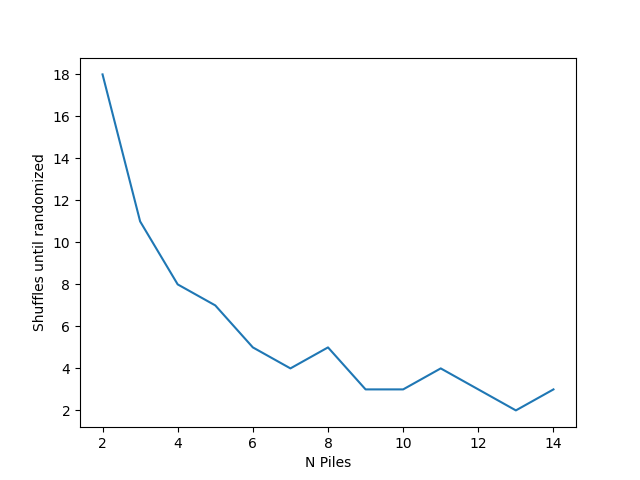

In [38]:
pl.figure()
pl.plot(n_piles, pile_7_reqd_shuffles)
pl.xlabel('N Piles')
pl.ylabel('Shuffles until randomized');

In [42]:
pl.close('all');


Results depend pretty strongly on number of piles. By about 7 - the default I used above because that's what I usually do in practice for some reason - we hit the point of diminishing returns, taking ~3 rounds of pile shuffling to hit a sufficiently randomized distribution of cards.

### Random vs. sequential piles for pile shuffling

In the pile shuffler above, I am dealing cards out into piles sequentially, as though dealing out `n_piles` hands in a card game, and introducing randomness by picking up the piles in random order.

What if we deal out cards into piles at random, then pick up at random? Do we achieve randomness with fewer shuffles for a given number of piles?

In [39]:
random_pile_kl_divs = []
random_pile_reqd_shuffles = []

for n_p in n_piles:

    these_pile_sim_results = s.simulate_shuffling(fresh_deck, s.RandomPilePileShuffler, n_piles=n_p)
    these_kl_divs = stats.get_kl_divs(these_pile_sim_results, ideal_distro)
    try:
        these_reqd_shuffles = np.where(these_kl_divs <= ideal_kl_thresh)[0][0] + 1
    except IndexError:
        these_reqd_shuffles = None

    random_pile_reqd_shuffles.append(these_reqd_shuffles)

/tmp/ipykernel_15319/2615068133.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  pl.figure()


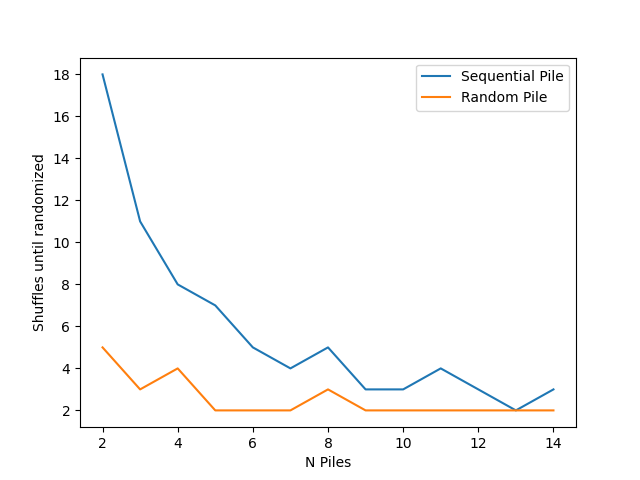

In [41]:
pl.figure()
pl.plot(n_piles, pile_7_reqd_shuffles, label='Sequential Pile')
pl.plot(n_piles, random_pile_reqd_shuffles, label='Random Pile')
pl.xlabel('N Piles')
pl.legend()
pl.ylabel('Shuffles until randomized');

Piling cards at random, not surprisingly, achieves randomness faster than piling sequentially regardless of # of piles. With enough piles, it seems you can even get away with just a couple of pile shuffles when piling randomly. Now, can you really pile randomly in practice? Probably not. So I'd probably err on more shuffles in practice.

### Riffle shuffling parameters

Here is how I simulate riffle shuffling:
- Split the deck roughly in half
- Select which half deck will start the shuffled pile
- Select how far into the selected half deck you go before introducing cards from the other half deck
- Randomly draw the number of cards introduced into the shuffled pile from each half deck, then switch to do the same from the other half deck until one half deck runs out of cards
- Add the remaining cards from the half deck that still has cards remaining

The key parameters of this method are:
- How do you select a deck to go first when combining two halves of the deck together?
- How much do you overlap the two halves before putting them together?
- What is the distribution of cards taken from one half of the deck before switching back to the other?

Let's explore these different factors.

### Which half deck riffles first?

I've implemented a few choices here. Either we always start with the same half deck, we swap halves of the deck that we start with between shuffles, or we choose at random every time. The random selection method is what I was doing above. So let's simulate both the fixed and swapping methods.

In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
fixed_half_riffle_sim_result = s.simulate_shuffling(fresh_deck, s.RiffleShuffler, half=0)
swap_half_riffle_sim_result = s.simulate_shuffling(fresh_deck, s.RiffleShuffler, half=0, swap_halves=True)

In [50]:
fixed_half_kl_divs = stats.get_kl_divs(fixed_half_riffle_sim_result, ideal_distro)
swap_half_kl_divs = stats.get_kl_divs(swap_half_riffle_sim_result, ideal_distro)

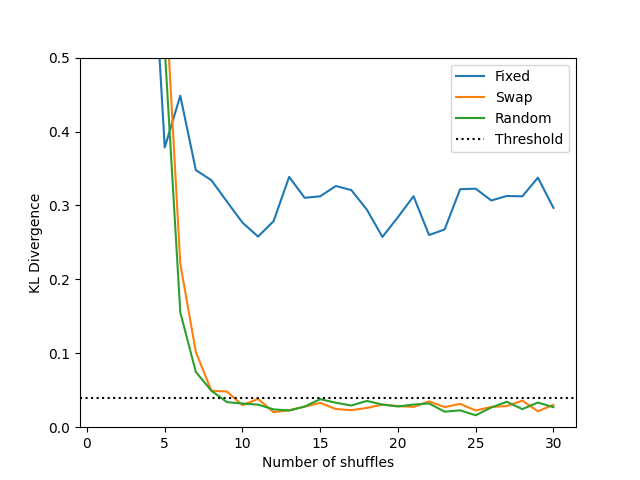

In [55]:
pl.figure()
pl.plot(n_shuffles, fixed_half_kl_divs, label='Fixed')
pl.plot(n_shuffles, swap_half_kl_divs, label='Swap')
pl.plot(n_shuffles, riffle_kl_divs, label='Random')
pl.axhline(ideal_kl_thresh, ls=':', c='k', label='Threshold')
pl.legend()
pl.ylim([0, 0.5])
pl.ylabel('KL Divergence')
pl.xlabel('Number of shuffles');

Very interesting. The fixed method never reaches randomness in the 30 shuffles we simuate. That is likely particularly true for the cards at the end of the deck, which is what we're measuring here given that we've marked card 0. There is effectively no difference between swapping which half is introduced first and selecting randomly.

In the simulations above, I'm inserting the 2nd half of the deck within the first 10% of the first half (so I start introducing cards from the 2nd half within a few cards). How important is that number?

In [56]:
intro_proportions = np.arange(0.1, 0.6, 0.1)
varying_intro_kl_divs = []

for ip in intro_proportions:
    this_sim_result = s.simulate_shuffling(fresh_deck, s.RiffleShuffler, intro_proportion=ip)
    this_kl_divs = stats.get_kl_divs(this_sim_result, ideal_distro)
    varying_intro_kl_divs.append(
        1 + np.where(this_kl_divs < ideal_kl_thresh)[0][0]
    )

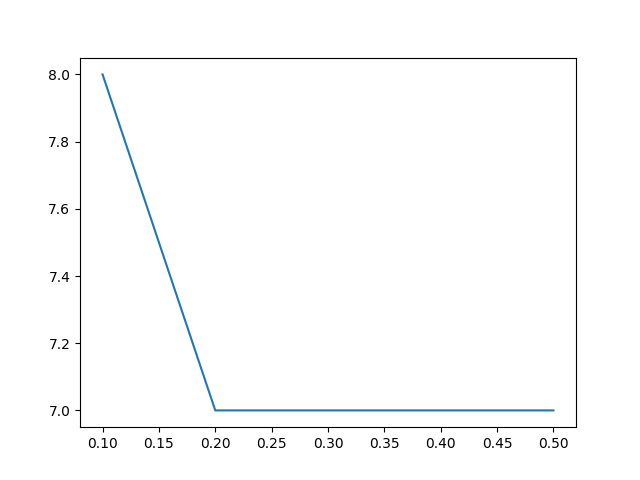

In [57]:
pl.figure()
pl.plot(intro_proportions, varying_intro_kl_divs)

It doesn't seem to matter much. Allowing for a little more overhang is perhaps slightly better, but only by one shuffle.

What about the distribution of cards introduced into the shuffled deck from a half of the deck before switching to the other half. I showed above that I'm using a distribution that heavily favors switching back and forth between deck halves one card at a time, occassionally taking 2 cards from a half. 

How much does this distribution matter? I'm going to always use a Poisson distribution, but I will vary the mean of the distribution (above I was using 0.5).  

In [66]:
distro_params = np.arange(0.05, 1.05, 0.05)
shuffle_distro_kl_divs = []

for dp in distro_params:
    distro = lambda: np.random.poisson(dp) + 1
    this_sim_result = s.simulate_shuffling(fresh_deck, s.RiffleShuffler, distro=distro, intro_proportion=0.2)
    this_kl_divs = stats.get_kl_divs(this_sim_result, ideal_distro)
    shuffle_distro_kl_divs.append(
        1 + np.where(this_kl_divs < ideal_kl_thresh)[0][0]
    )

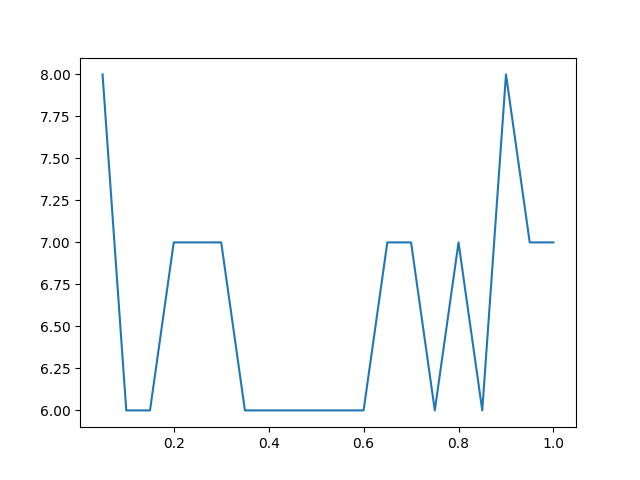

In [67]:
pl.figure()
pl.plot(distro_params, shuffle_distro_kl_divs)

No clear trend. I'm going to say it doesn't matter much I guess?

## Real data

Last night while watching [GBBO](https://thegreatbritishbakeoff.co.uk/) I decided to shuffle up some cards and collect some data to see how close reality matches my simulations. 

I used a deck of 60 cards (a [Solforge Fusion](https://solforgefusion.com/) deck, if you're curious... great game BTW) sleeved in Dragon Shield sleeves. 58 of the 60 cards were sleeved in one color (Crypt, if you're curious), but I sleeved 2 cards in a different color (Petrol) to act as my marked cards for measurement. The two different colored sleeves were of the same finish so the marked cards would not feel different.

I started with the two marked cards at the top of the deck, then "smash" shuffled 9 times. The simulation results above indicate that the deck should be fully shuffled after 9 shuffles. Following what I learned above, I made sure to swap back and forth between starting with the top half of the deck or the bottom half. After 9 shuffles, I recorded the distance between the two marked cards. Then I reset the deck and repeated the process 50 times.  

Let's compare the distribution of distances from these 50 shuffles to both theory and simulation.

In [84]:
pl.close('all')

In [75]:
with open('../data/riffle_shuffling_data_9_shuffles.csv', 'r') as f:
    lines = f.readlines()

real_data = [int(l) for l in lines if len(l) > 0]

I only collected 50 data points, far less than the number of samples I collected in my simulations above. My data will be a lot noisier than the sims as a result. To better compare simulation and data, I'm going to run some smaller simulations, computing a new KL divergence threshold for a distribution of 50 samples.

In [78]:
n = 9
small_sim_result_kl_divs = []
for i in range(30):

    small_sim_results = s.simulate_shuffling(fresh_deck, s.RiffleShuffler, 50)
    small_sim_result_kl_divs.append(stats.kl_divergence(
        stats.get_distro(small_sim_results[n]), ideal_distro
    ))
    


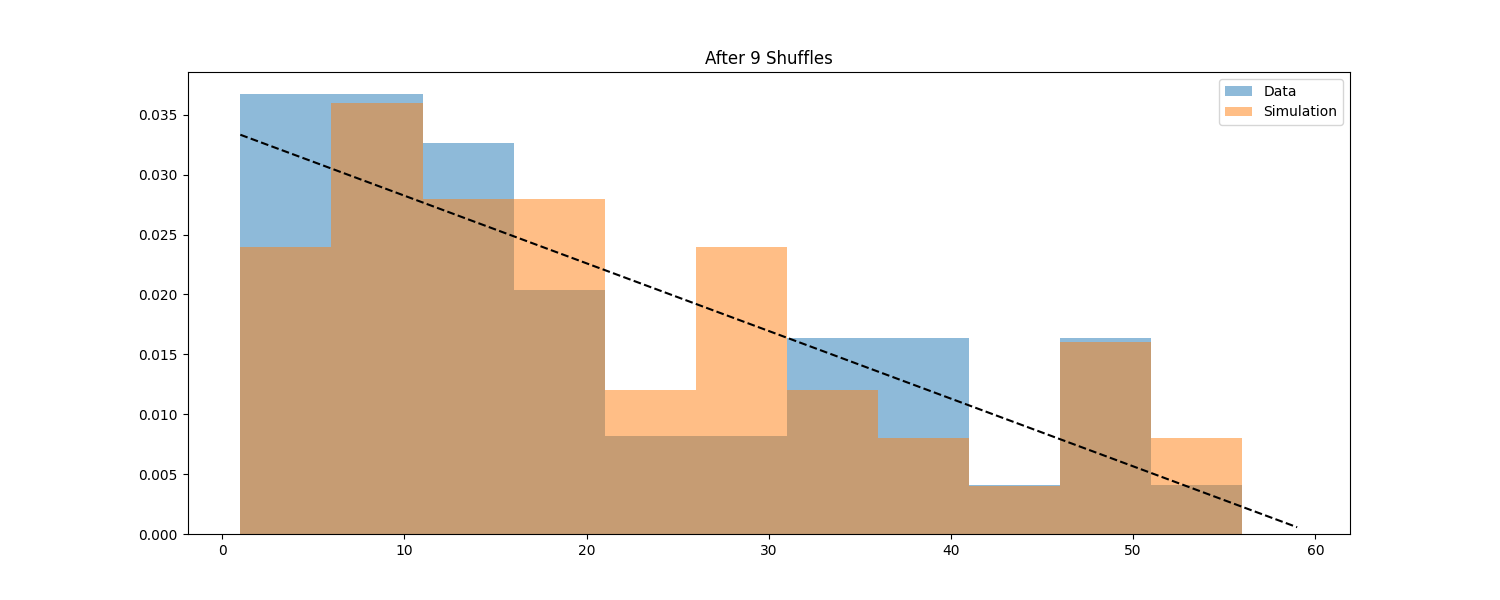

In [ ]:
pl.figure(figsize=(15,6))
pl.hist(real_data, bins=np.arange(1, 60, 5), density=True, alpha=0.5, label='Data')
pl.plot(dists, ideal_distro, '--k')
pl.hist(small_sim_results[9], bins=np.arange(1, 60, 5), density=True, alpha=0.5, label='Simulation')
pl.title(f'After 9 Shuffles')
pl.legend()

These distribution of the data looks qualitatively similar to the distribution of one of my 50 shuffle simulations, and follows the expected trend where shorter distances are more likely than larger distances. But as expected, the results are noisy compared to the larger simulation runs I was doing previously. Let's look at the KL divergence of my smaller simulation runs and compare to the KL divergence of the data (both KL divergences relative to the ideal distribution).

In [87]:
print(f"{np.mean(small_sim_result_kl_divs):.2f} +- {np.std(small_sim_result_kl_divs) * 2:.2f}")

0.59 +- 0.15


In [88]:
stats.kl_divergence(stats.get_distro(real_data), ideal_distro) 


0.6575524559912331

The KL divergence of the data distribution, relative to the ideal, is consistent with simulations! What does that tell me? I guess it tells me that I can have some confidence that I am able to physically shuffle the cards in a way that matches my simulations, and that I can therefore have some confidence that simulation results will hold in the real world.

## Optimizing shuffling strategy

Pile shuffling gets you a result with fewer shuffles than riffle shuffling, but riffle shuffling is faster to execute so you can do more of them in the same amount of time. 

Something that I do and I see a lot of others do is do a single pile shuffle, then riffle shuffle a number of times before dealing out. How does this compare to just riffle shuffling?

In [74]:
pile_then_riffle_sim_results = s.simulate_shuffling(fresh_deck, s.PileThenRiffleShuffler)

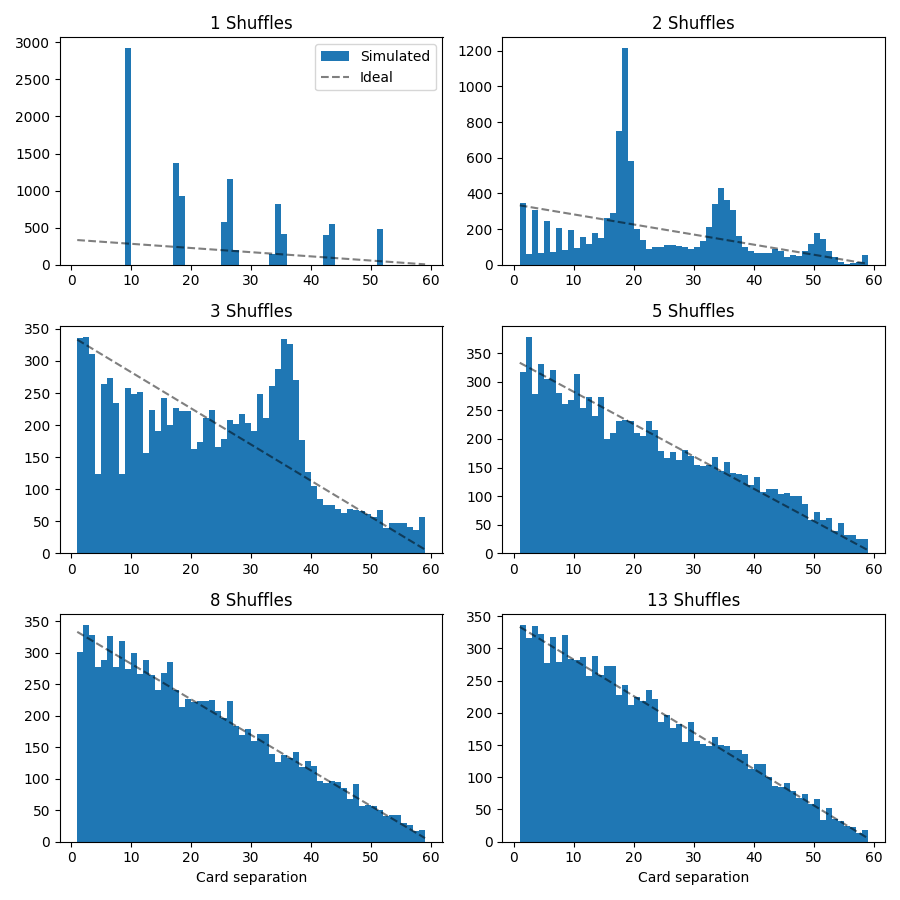

In [ ]:
pile_then_riffle_kl_divs = stats.get_kl_divs(pile_then_riffle)

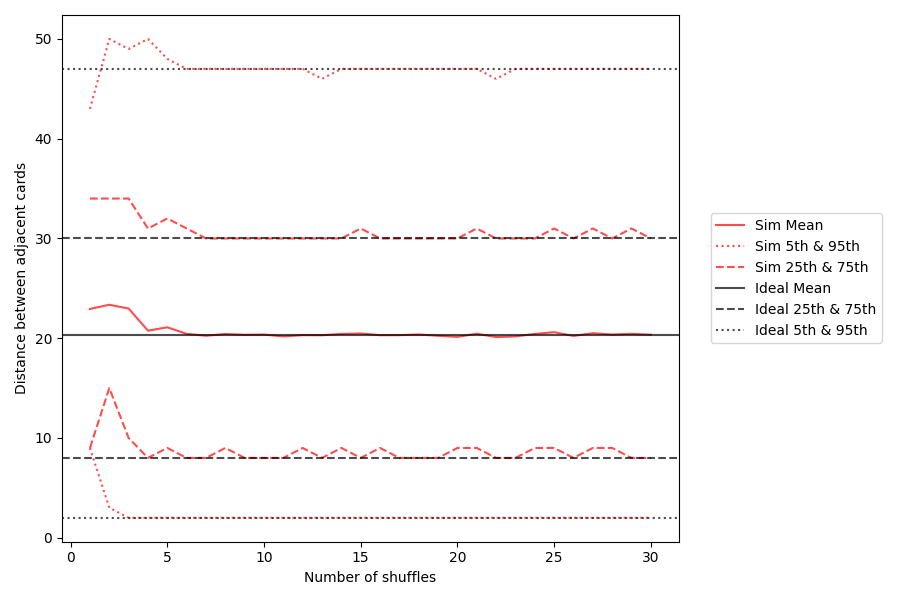

In [ ]:
_ = v.plot_sim_summary(pile_then_riffle_sim_results, ideal_stats)

A bit, yes. It takes something more like 5-6 shuffles (1 pile + 4-5 riffle) compared to 10+ shuffles for pure riffle shuffling. This is closer to the same number of shuffles as pile shuffling, but riffle shuffling is faster, so this might be the faster approach? At least it seems like my perception that this leads to better results in practice with fewer riffle shuffles is correct.

Another thing that I do, and see others do as well, is to riffle shuffle but mix in some cuts every few shuffles. Does this work better than pure riffle shuffling? By default I cut every 3rd shuffle, meaning I go riffle-riffle-cut on repeat.


In [ ]:
riffle_cut_sim_results = s.simulate_shuffling(fresh_deck, s.RiffleCutShuffler)

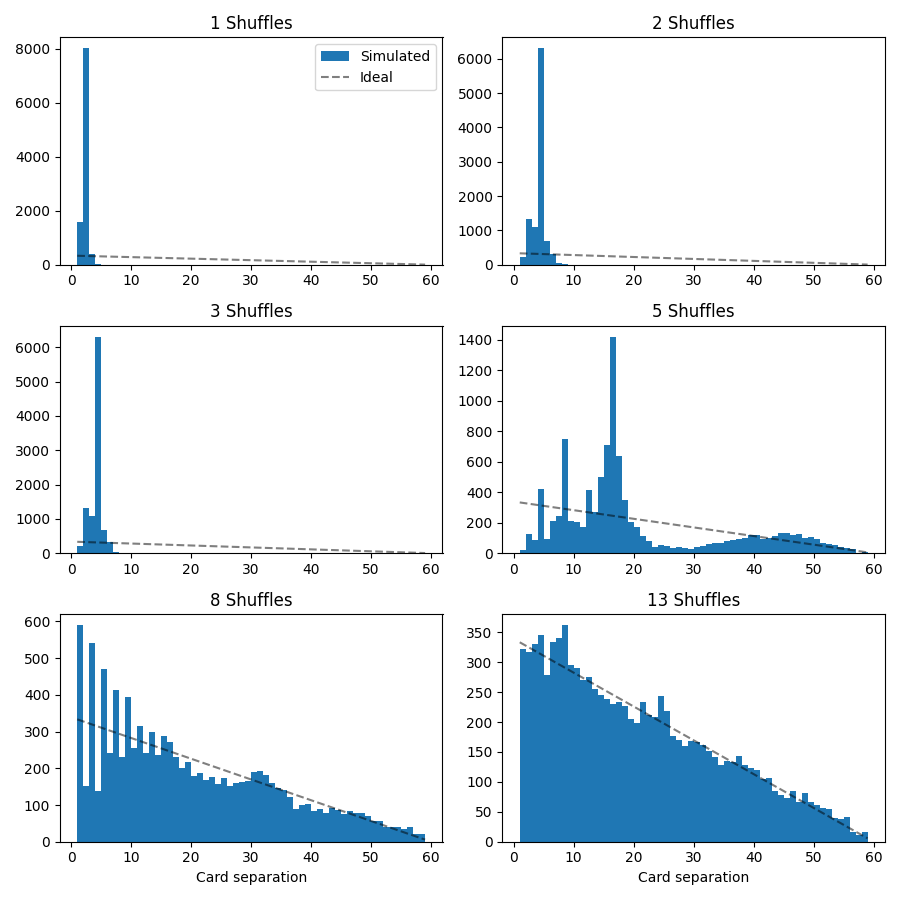

In [ ]:
v.plot_histograms(riffle_cut_sim_results, dists, ideal_distro)

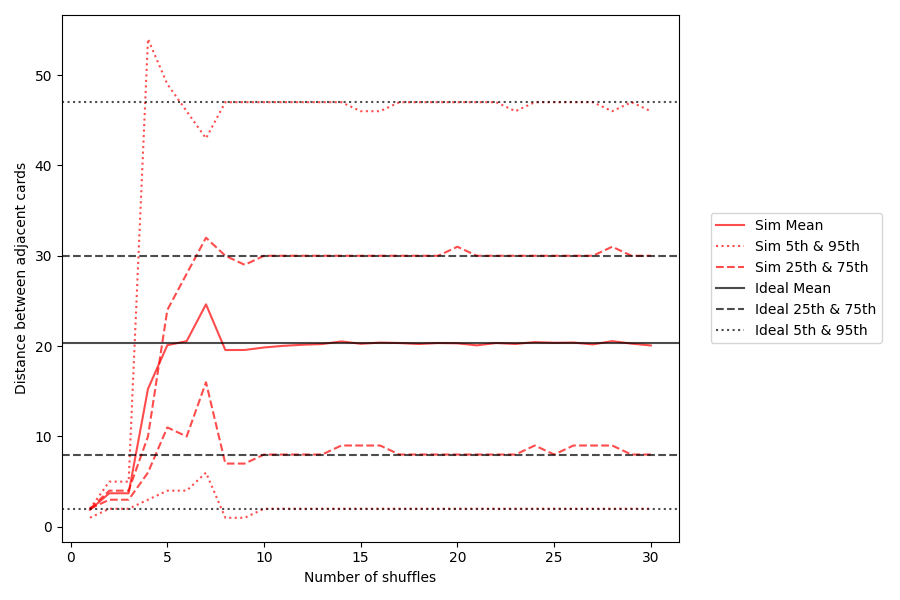

In [ ]:
_ = v.plot_sim_summary(riffle_cut_sim_results, ideal_stats)

## Conclusions